In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimization
from scipy.optimize import least_squares
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [2]:
df1 = pd.read_csv('df_ant1_30.csv') # in each channel we have 96 data points per antenna
df2 = pd.read_csv('df_ant2_30.csv')
df3 = pd.read_csv('df_ant3_30.csv')

In [3]:
t = df1[df1.Channel >= 11]
t['omega'] = (t['Channel']-11)*2+ 2428.25
tless = df1[df1.Channel < 11]
tless['omega'] = (tless['Channel'])*2 + 2404.25
df1 = t.append(tless)

<ipython-input-3-3d26178556e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['omega'] = (t['Channel']-11)*2+ 2428.25
<ipython-input-3-3d26178556e0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tless['omega'] = (tless['Channel'])*2 + 2404.25


In [4]:
X12 = (df1['I'] + 1j*df1['Q']) * (df2['I'] - 1j*df2['Q'])
X23 = (df2['I'] + 1j*df2['Q']) * (df3['I'] - 1j*df3['Q'])
X13 = (df1['I'] + 1j*df1['Q']) * (df3['I'] - 1j*df3['Q'])

In [5]:
d = {'channel': df1['Channel'],'omega':df1['omega'],'x12': X12, 'x23': X23, 'x13': X13, 'idx1':df1['sample_idx'], 'idx2':df2['sample_idx'], 'idx3':df3['sample_idx']}
data = pd.DataFrame(data=d)
data['phi12'] = np.angle(X12)* 180/(2*np.pi)
data['phi23'] = np.angle(X23)* 180/(2*np.pi)
data['phi13'] = np.angle(X13)* 180/(2*np.pi)
data['mag23'] = np.abs(X23)
# data.to_csv('phi_30degree.csv', index = False)

#### Another kalman filter
Here the Q and R is changing for each part. in the loop! 
This is not necessary, beacuse after a while, this will stay the same. So, not required. Haha!!

In [6]:
sdata = data

In [7]:
t = 2.5e-8
error_est_x = 55-16;
error_est_v = 5;
v = 2404
def prediction2d(x, v, t):
    A = np.array([[1, t],
                  [0, 1]])
    X = np.array([[x],
                  [v]])
    X_prime = A.dot(X) 
    return X_prime

def covariance2d(sigma1, sigma2):
    cov1_2 = sigma1 * sigma2
    cov2_1 = sigma2 * sigma1
    cov_matrix = np.array([[sigma1 ** 2, cov1_2],
                           [cov2_1, sigma2 ** 2]])
    return np.diag(np.diag(cov_matrix))

Xi = []
Z = []
# Initial Estimation Covariance Matrix
P = covariance2d(error_est_x, error_est_v)
A = np.array([[1, t],
              [0, 1]])
# error_obs_x = int(sdata['phi23'].std()/sdata['mag23'].std())
error_obs_x = int(sdata['phi23'].std())
error_obs_v = int(sdata['omega'].std())
for i in range(0, len(data),96):
    x_observations = sdata['phi23'][i:i+96]
    v_observations = sdata['omega'][i:i+96]
    v = sdata['omega'][i:i+96]
    z = np.c_[x_observations, v_observations]
    Z.append(z)

    
    # Initial State Matrix
    X = np.array([[z[0][0]],
                  [v[i]]])

    Xi.append(X)

    n = len(z[0])


In [8]:
results = []
for i in range(len(Z)):
    z = Z[i]
    X = Xi[i]
    for data in z[1:]:
        X = prediction2d(X[0][0], X[1][0], t)
        # To simplify the problem, professor
        # set off-diagonal terms to 0.
        P = np.diag(np.diag(A.dot(P).dot(A.T)))

        # Calculating the Kalman Gain
        H = np.identity(n)
        R = covariance2d(error_obs_x, error_obs_v)
        S = H.dot(P).dot(H.T) + R
        from numpy.linalg import inv
        K = P.dot(H).dot(inv(S))
        del inv

        # Reshape the new data into the measurement space.
        Y = H.dot(data).reshape(n, -1)

        # Update the State Matrix
        # Combination of the predicted state, measured values, covariance matrix and Kalman Gain
        X = X + K.dot(Y - H.dot(X))
        
        # Update Process Covariance Matrix
        P = (np.identity(len(K)) - K.dot(H)).dot(P)
    results.append(X)

print("Kalman Filter State Matrix:\n", X)

Kalman Filter State Matrix:
 [[  23.22645278]
 [2436.25      ]]


In [9]:
sdata['phi23'].std(), P, sdata['omega'].std()

(25.696906720445945,
 array([[0.0888995 , 0.        ],
        [0.        , 0.06865872]]),
 22.08672076582003)

In [10]:
np.average(sdata['phi23']), len(Z), len(Z[0])

(16.448798889914162, 74, 96)

In [11]:
phi23 = []
omega23 = []
for i in range(len(results)):
    phi23.append(results[i][0])
    omega23.append(results[i][1])
    

In [12]:
np.average(phi23), np.average(omega23)

(21.42879756506326, 2441.6554054054054)

In [13]:
d = []
for i in range(len(results)):
    t = results[i][0]
    t2 = results[i][1]
    d.append({"phi23": t[0], "omega":t2[0]})
phi23 = pd.DataFrame(d)

array([<AxesSubplot:>], dtype=object)

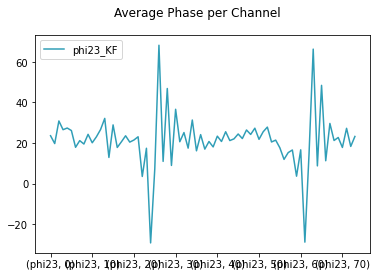

In [14]:
phi23.unstack(level=0)[['phi23']].plot(subplots=True, title="Average Phase per Channel", color= '#309EB7', label='phi23_KF', legend=True)

In [15]:
phi23['theta23'] = ((2.9*1e10)/(3.5*2*np.pi)*(1/phi23['omega'])*10**-6*phi23['phi23'])

array([<AxesSubplot:>], dtype=object)

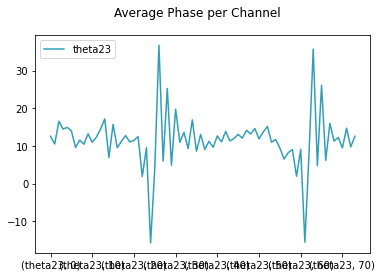

In [16]:
phi23.unstack(level=0)[['theta23']].plot(subplots=True, title="Average Phase per Channel", color= '#309EB7', label='theta23', legend=True)

In [17]:
phi23['phi23'].std(), np.max(phi23['phi23']), phi23['theta23'].std(), np.max(phi23['theta23'])

(13.619215912327691, 68.24306521322256, 7.340811061967122, 36.78813503495219)

In [18]:
np.average(phi23['theta23'])

11.569806838678945

## The pakage inv is wierd
dont run unless u are defenetly required! 
yet the above kalman filter, functions better